<a href="https://colab.research.google.com/github/kloud80/urban-data-mining/blob/master/pandana_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 91.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 115.2 MB/s eta 0:00:00


In [ ]:
pip install osmnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install pandana

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pandana-0.6.1-cp310-cp310-linux_x86_64.whl
  Using cached tables-3.6.1.tar.gz (4.6 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tables
  Running setup.py clean for tables
Failed to build tables
ERROR: Could not build wheels for tables, which is required to install pyproject.toml-based projects


In [ ]:
import osmnx as ox
import pandana
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

ModuleNotFoundError: ignored

In [ ]:
# Select city and crs
cityname = 'goyang-si, korea'
crs = 5179

In [ ]:
# Get graph by geocoding
graph = ox.graph_from_place(cityname, network_type="walk")

# Project graph
graph = ox.projection.project_graph(graph, to_crs=crs)

In [ ]:
# Select points of interest based on osm tags
tags = {
    'amenity':[
        'cafe',
        'bar',
        'pub',
        'restaurant'
    ],
    'shop':[
        'bakery',
        'convenience',
        'supermarket',
        'mall',
        'department_store',
        'clothes',
        'fashion',
        'shoes'
    ],
    'leisure':[
        'fitness_centre'
    ]
}

# Get amentities from place
pois = ox.geometries.geometries_from_place(cityname, tags=tags)

# Project pois
pois = pois.to_crs(epsg=crs)

In [ ]:
# Max time to walk in minutes (no routing to nodes further than this)
walk_time = 15

# Walking speed
walk_speed = 4.5

# Set a uniform walking speed on every edge
for u, v, data in graph.edges(data=True):
    data['speed_kph'] = walk_speed
graph = ox.add_edge_travel_times(graph)

# Extract node/edge GeoDataFrames, retaining only necessary columns (for pandana)
nodes = ox.graph_to_gdfs(graph, edges=False)[['x', 'y']]
edges = ox.graph_to_gdfs(graph, nodes=False).reset_index()[['u', 'v', 'travel_time']]

In [ ]:
# Construct the pandana network model
network = pandana.Network(
    node_x=nodes['x'],
    node_y=nodes['y'],
    edge_from=edges['u'],
    edge_to=edges['v'],
    edge_weights=edges[['travel_time']]
)

# Extract centroids from the pois' geometries
centroids = pois.centroid

In [ ]:
# Specify a max travel distance for analysis
# Minutes -> seconds
maxdist = walk_time * 60

# Set the pois' locations on the network
network.set_pois(
    category='pois',
    maxdist=maxdist,
    maxitems=10,
    x_col=centroids.x,
    y_col=centroids.y
)

/usr/local/lib/python3.8/dist-packages/pandana/network.py:660: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/usr/local/lib/python3.8/dist-packages/pandana/network.py:668: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


In [ ]:
# calculate travel time to 10 nearest pois from each node in network
distances = network.nearest_pois(
    distance=maxdist,
    category='pois',
    num_pois=10
)

distances.astype(int).head()

,1,2,3,4,5,6,7,8,9,10
osmid,,,,,,,,,,
296061934,286,564,647,667,709,721,764,778,816,816
9274134974,282,561,643,657,705,717,754,774,812,812
3462615769,470,747,831,850,893,900,900,900,900,900
9274134971,276,554,637,669,699,711,757,768,806,806
9274134972,281,558,642,674,703,715,761,772,810,810


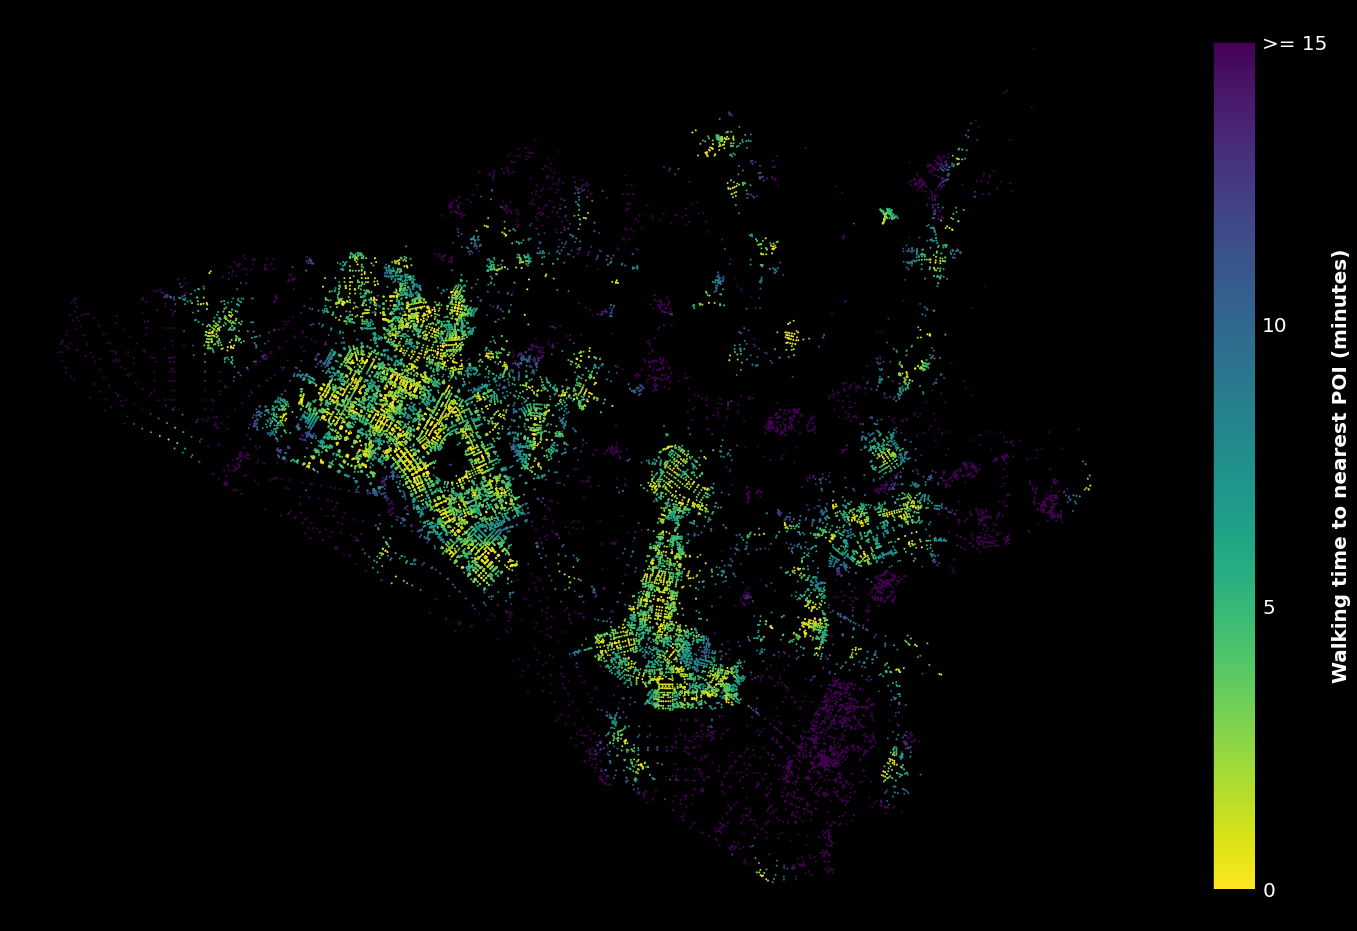

In [ ]:
# Set text parameters
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

# Setup plot
fig, ax = plt.subplots(figsize=(20,15))
ax.set_axis_off()
ax.set_aspect('equal')
fig.set_facecolor((0,0,0))

# Plot distance to nearest POI
sc = ax.scatter(
    x=nodes['x'],
    y=nodes['y'],
    c=distances[1],
    s=1,
    cmap='viridis_r',
)

# Colorbar
cb = fig.colorbar(sc, ax=ax, shrink=0.8, ticks=[0, 300, 600, 900])
cb.ax.tick_params(color='none', labelsize=20)
cb.ax.set_yticklabels(['0', '5', '10', '>= 15'])
cb.set_label('Walking time to nearest POI (minutes)', fontsize=20, fontweight='bold')

# Remove empty space
plt.tight_layout()

plt.show()

<ipython-input-11-03f6bf2d0354>:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


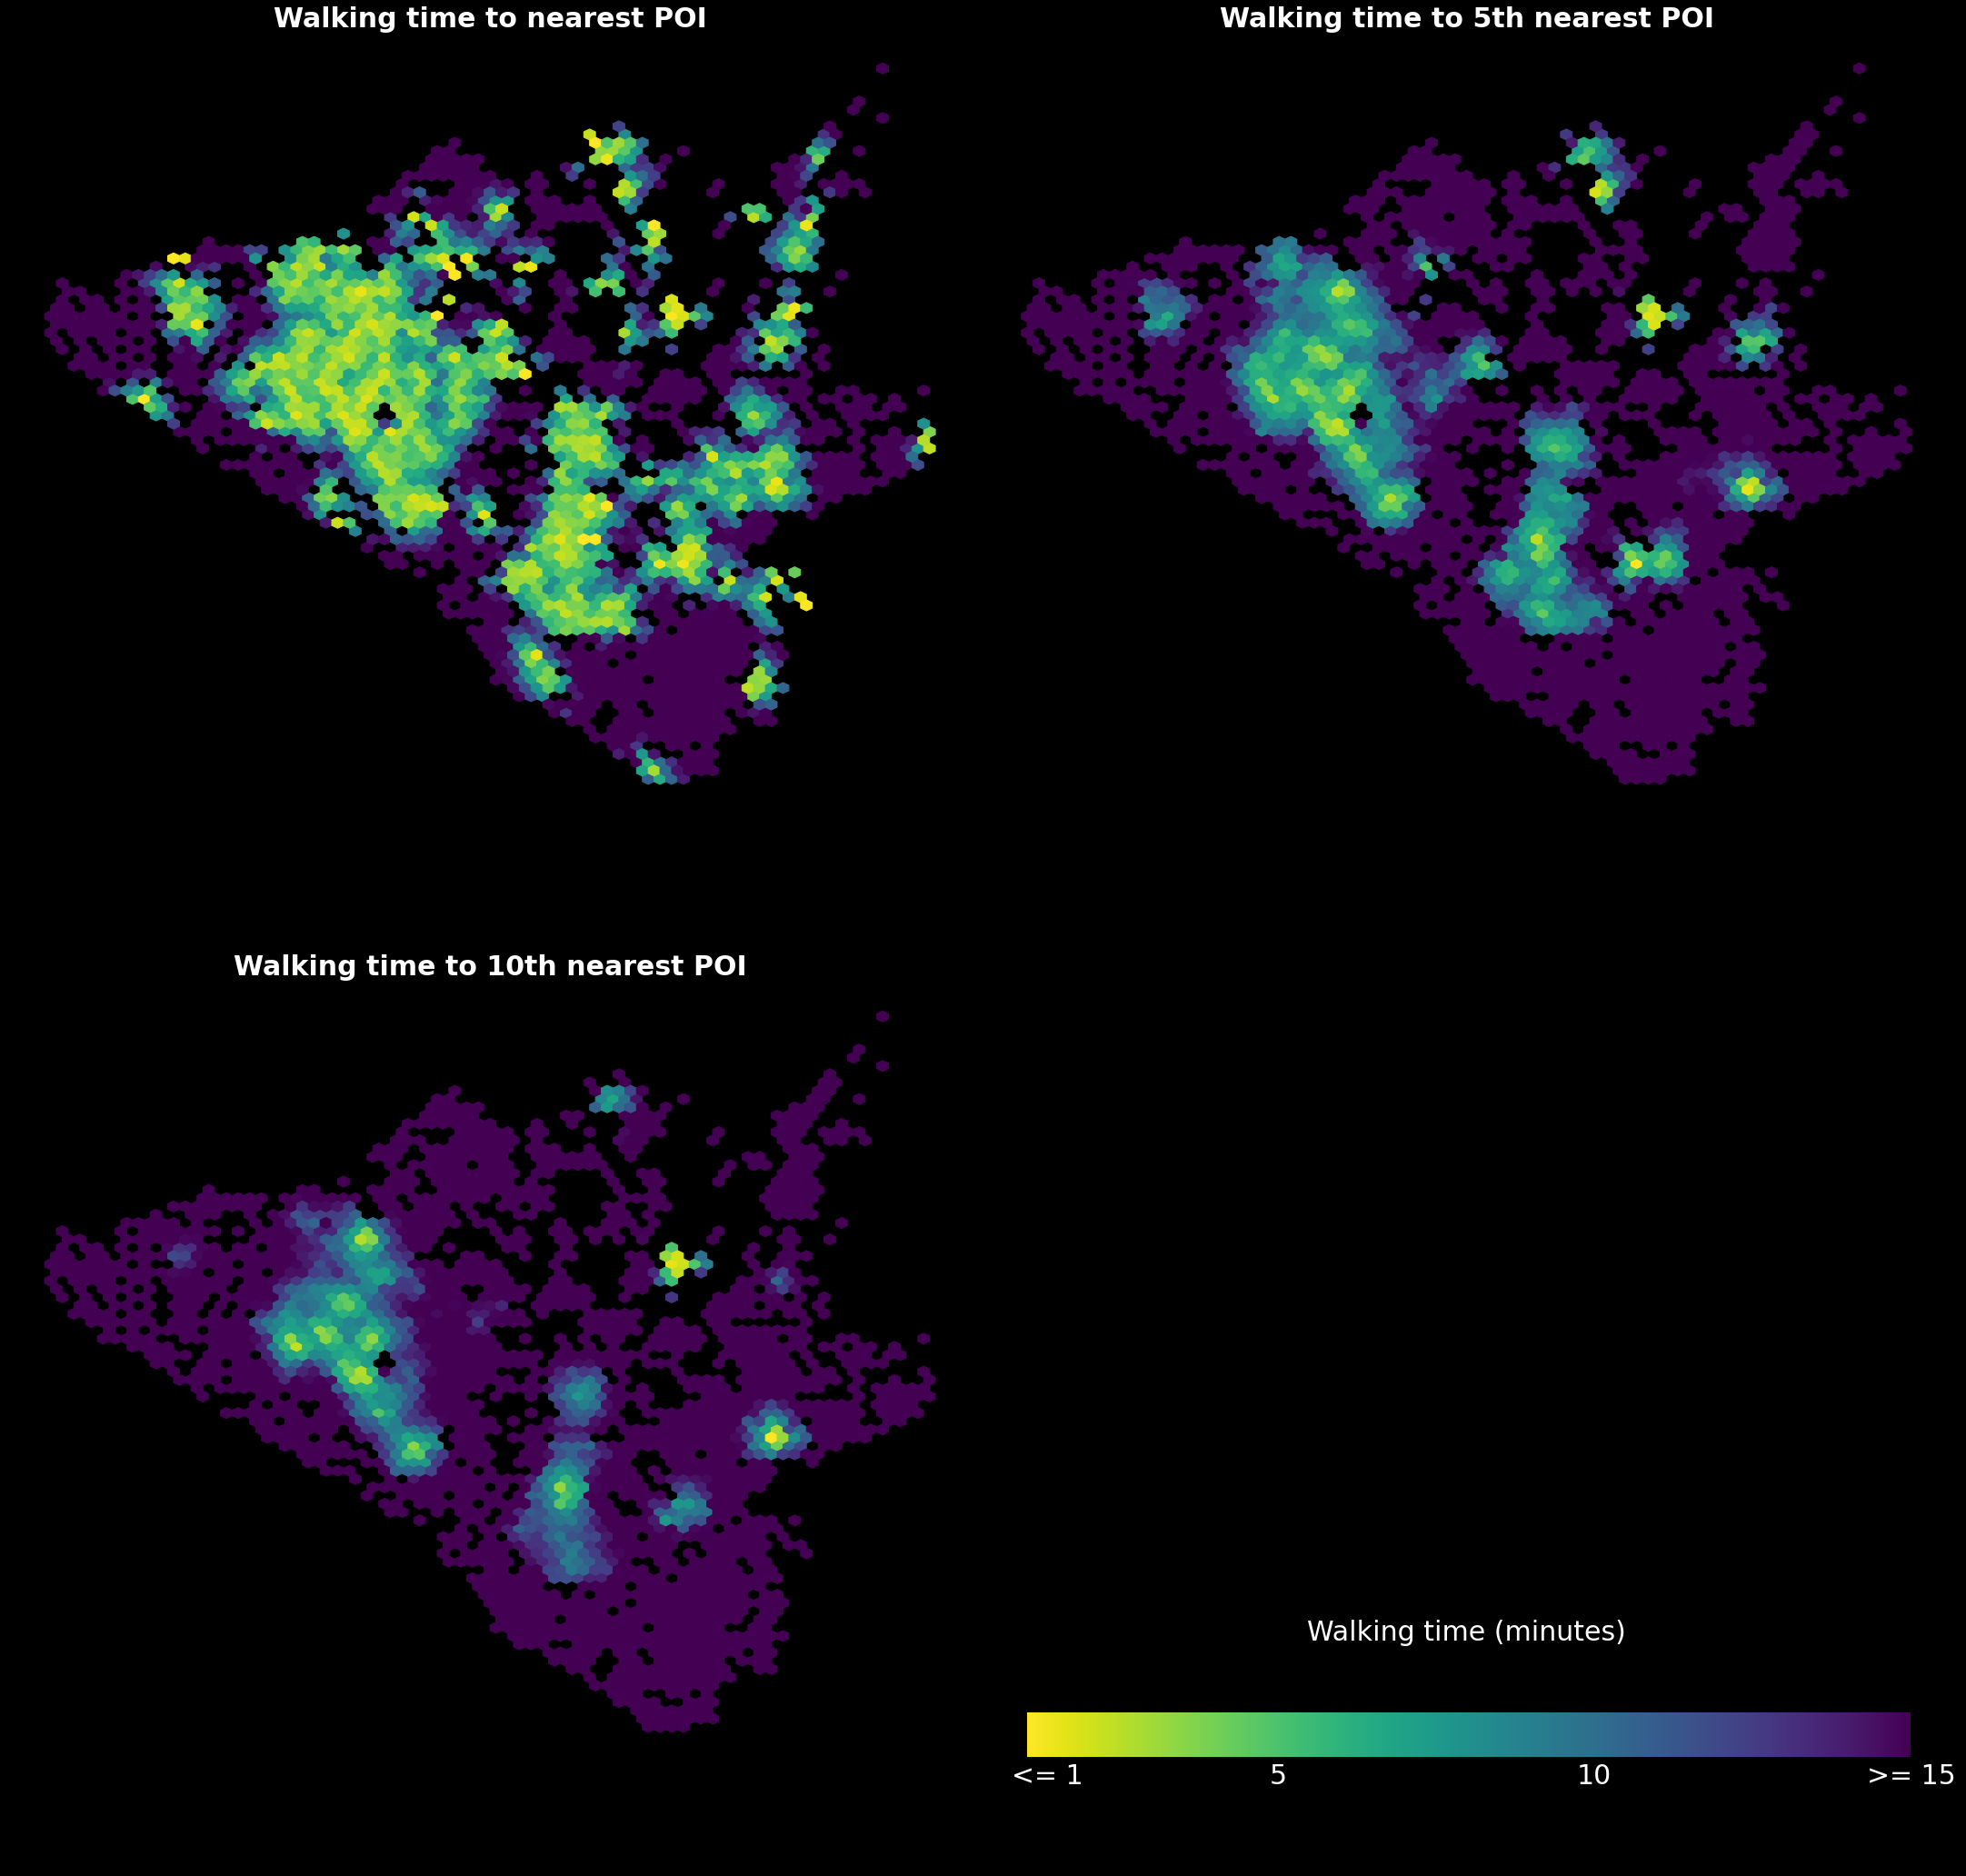

In [ ]:
# Setup plot
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(30,30), constrained_layout=False)
ax[0][0].set_axis_off()
ax[0][1].set_axis_off()
ax[1][0].set_axis_off()
ax[1][1].set_axis_off()
ax[0][0].set_aspect('equal')
ax[0][1].set_aspect('equal')
ax[1][0].set_aspect('equal')

# Specify colors
fig.set_facecolor('black')
cmap = 'viridis_r'

# Plot distance to nearest POI
hb = ax[0][0].hexbin(
    x=nodes['x'],
    y=nodes['y'],
    gridsize=75,
    cmap=cmap,
    C=distances[1],
    alpha=1
)

# Plot distance to 5th nearest POI
hb = ax[0][1].hexbin(
    x=nodes['x'],
    y=nodes['y'],
    gridsize=75,
    cmap=cmap,
    C=distances[5],
    alpha=1
)

# Plot distance to 10th nearest POI
hb = ax[1][0].hexbin(
    x=nodes['x'],
    y=nodes['y'],
    gridsize=75,
    cmap=cmap,
    C=distances[10],
    alpha=1
)

# Add titles to maps
ax[0][0].set_title('Walking time to nearest POI', fontsize=30, fontweight='bold')
ax[0][1].set_title('Walking time to 5th nearest POI', fontsize=30, fontweight='bold')
ax[1][0].set_title('Walking time to 10th nearest POI', fontsize=30, fontweight='bold')

# Setup color bar axis (location of color bar)
cbar_ax = fig.add_axes([0.5, 0.01, 0.5, 0.5])
cbar_ax.set_axis_off()

# Color bar properties
cb = plt.colorbar(
    hb,
    ax=cbar_ax,
    shrink=0.9,
    ticks=[82, 300, 600, 900],
    orientation='horizontal',
    aspect=20
)
cb.outline.set_edgecolor('none')
cb.ax.tick_params(color='none', labelsize=30)
cb.ax.set_xticklabels(['<= 1', '5', '10', '>= 15'])

# Title for color bar
ax[1][1].text(0.5, 0.23, 'Walking time (minutes)', fontsize=30, ha='center')

# Tight layout
plt.tight_layout()

# Save
# plt.savefig('./docs/walk_access_comparison.png')
plt.show()